In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import os,sys
import torchvision.transforms as transforms
# os.environ["https_proxy"]="10.10.20.100:1089"
# os.environ["https_proxy"]="127.0.0.1:7890"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
sys.path.append('..')
sys.path.append('.')
%load_ext autoreload
%autoreload 2

In [ ]:
# LOAD VAE

import os
import time
from pathlib import Path
from loguru import logger
from datetime import datetime
import torch

from hyvideo.utils.file_utils import save_videos_grid
from hyvideo.config import parse_args
from hyvideo.inference import HunyuanVideoSampler
from hyvideo.vae.autoencoder_kl_causal_3d import AutoencoderKLCausal3D
import hyvideo.config
print(hyvideo.config.__file__)
from hyvideo.config import *
string_args="""--video-size 720 1280 --video-length 129 --infer-steps 50 --prompt cat. --flow-reverse --use-cpu-offload --save-path ./results"""
string_args=string_args.split(" ")
print(string_args)

def parse_args_with_string(string_args,namespace=None):
    parser = argparse.ArgumentParser(description="HunyuanVideo inference script")

    parser = add_network_args(parser)
    parser = add_extra_models_args(parser)
    parser = add_denoise_schedule_args(parser)
    parser = add_inference_args(parser)
    parser = add_parallel_args(parser)

    args = parser.parse_args(string_args,namespace=namespace)
    args = sanity_check_args(args)

    return args

args = parse_args_with_string(string_args=string_args)
print(args)

from hyvideo.modules import load_model
from hyvideo.vae import load_vae

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

vae, _, s_ratio, t_ratio = load_vae(
            args.vae,
            args.vae_precision,
            logger=logger,
            device=device,
        )
vae:AutoencoderKLCausal3D
vae.enable_tiling()


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def read_yuv_file(file_path, width, height, resize_width,resize_height):
    # 计算YUV文件的大小
    frame_size = width * height
    y_size = frame_size
    u_size = frame_size // 4
    v_size = frame_size // 4
    frames=[]
    with open(file_path, 'rb') as f:
        while True:
            # f.read(0)
            y = f.read(y_size)
            v = f.read(v_size)
            u = f.read(u_size)

            if not y or not u or not v:
                break  # 文件结束

            # 将字节数据转换为numpy数组
            Y = np.frombuffer(y, dtype=np.uint8).reshape((height, width))
            U = np.frombuffer(u, dtype=np.uint8).reshape((height // 2, width // 2))
            V = np.frombuffer(v, dtype=np.uint8).reshape((height // 2, width // 2))

            # 上采样U和V分量
            U_up = cv2.resize(U, (width, height), interpolation=cv2.INTER_LINEAR)
            V_up = cv2.resize(V, (width, height), interpolation=cv2.INTER_LINEAR)

            # 合并YUV分量为BGR格式
            yuv = cv2.merge((Y, U_up, V_up))
            bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
            bgr = cv2.resize(bgr,(resize_width,resize_height))
            frames.append(bgr)
    return frames


In [5]:
from pytorch_msssim import ssim as calc_ssim_func

def calculate_video_content_info_ssim(videos1):
    # print("calculate_content_info_ssim...")
    # videos [batch_size, timestamps, channel, h, w]

    ci_ssim_results = []

    for video_num in (range(videos1.shape[0])):
        # get a video
        # video [timestamps, channel, h, w]
        video1 = videos1[video_num].mul(255).add_(0.5).clamp_(0, 255)

        img1 = video1[:-1]
        img2 = video1[1:]
        ssim_val=calc_ssim_func(img1, img2, data_range=255, size_average=True)
        # print(ssim_val)
        ci_ssim_results.append(1-ssim_val.item())
    return ci_ssim_results

In [40]:
path="/mnt/public/wangsiyuan/k8bfn0qsj9fs1rwnc2x75z6t7/BVI-HFR/30hz/"
fps = 30
from tqdm import tqdm

datas_ci=[]
datas_latent_x=[]
datas_latent_y=[]

n_frames=67

for filename in tqdm(os.listdir(path)):
    if filename.endswith(".yuv"):
        video_path = path+filename  # 替换为你的视频文件路径
        raw_frames=read_yuv_file(video_path, width=1920, height=1080,resize_width=960,resize_height=528)
        # 存储视频帧的亮度值
        
        frames=[]
        tensor_frames=[]
        for frame in raw_frames:
            # 将帧转换为灰度图并获取亮度值
            tensor_frame = transforms.ToTensor()(frame)
            tensor_frames.append(tensor_frame)

        for frame_st in range(0,len(tensor_frames)-n_frames+1,n_frames):
            print(f"===== process {filename} frame {frame_st} =====")
            video_tensor = torch.stack(tensor_frames[frame_st:frame_st+n_frames])          # (T, C, H, W)
            ci=calculate_video_content_info_ssim(video_tensor.unsqueeze(0))[0] # (0,1)范围
            datas_ci.append(ci)

            video_tensor = video_tensor.permute(1, 0, 2, 3) # (C, T, H, W)

            video_tensor = 2 * video_tensor - 1         # [-1, 1]范围

            x=video_tensor.unsqueeze(0).half().cuda()
            y=vae.encode(x)

            signal = y.latent_dist.mean.permute(0,1,3,4,2)
            signal = signal.reshape(-1,signal.shape[-1]).cpu().numpy()

            print(signal.shape)

            # 进行离散傅里叶变换
            frequencies = np.fft.fft(signal,axis=1)
            frequencies_magnitude = np.abs(frequencies).mean(axis=0)
            frequencies_magnitude = frequencies_magnitude[1:]

            fft_freq = np.fft.fftfreq(signal.shape[1], 4/fps)
            fft_freq = fft_freq[1:]

            datas_latent_x.append(np.abs(fft_freq))
            datas_latent_y.append(frequencies_magnitude)


  0%|          | 0/22 [00:00<?, ?it/s]

===== process hamster-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process hamster-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process hamster-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process hamster-30fps-360-1920x1080.yuv frame 201 =====


  5%|▍         | 1/22 [01:05<22:48, 65.16s/it]

(126720, 17)
===== process books-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process books-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process books-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process books-30fps-360-1920x1080.yuv frame 201 =====


  9%|▉         | 2/22 [02:10<21:48, 65.43s/it]

(126720, 17)
===== process pond-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process pond-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process pond-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process pond-30fps-360-1920x1080.yuv frame 201 =====


 14%|█▎        | 3/22 [03:16<20:49, 65.77s/it]

(126720, 17)
===== process martial_arts-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process martial_arts-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process martial_arts-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process martial_arts-30fps-360-1920x1080.yuv frame 201 =====


 18%|█▊        | 4/22 [04:23<19:47, 65.95s/it]

(126720, 17)
===== process bouncyball-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process bouncyball-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process bouncyball-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process bouncyball-30fps-360-1920x1080.yuv frame 201 =====


 23%|██▎       | 5/22 [05:29<18:46, 66.25s/it]

(126720, 17)
===== process cyclist-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process cyclist-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process cyclist-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process cyclist-30fps-360-1920x1080.yuv frame 201 =====


 27%|██▋       | 6/22 [06:36<17:42, 66.42s/it]

(126720, 17)
===== process golf_side-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process golf_side-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process golf_side-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process golf_side-30fps-360-1920x1080.yuv frame 201 =====


 32%|███▏      | 7/22 [07:43<16:37, 66.47s/it]

(126720, 17)
===== process leaves_wall-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process leaves_wall-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process leaves_wall-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process leaves_wall-30fps-360-1920x1080.yuv frame 201 =====


 36%|███▋      | 8/22 [08:50<15:32, 66.62s/it]

(126720, 17)
===== process plasma-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process plasma-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process plasma-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process plasma-30fps-360-1920x1080.yuv frame 201 =====


 41%|████      | 9/22 [09:56<14:25, 66.60s/it]

(126720, 17)
===== process lamppost-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process lamppost-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process lamppost-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process lamppost-30fps-360-1920x1080.yuv frame 201 =====


 45%|████▌     | 10/22 [11:03<13:19, 66.61s/it]

(126720, 17)
===== process flowers-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process flowers-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process flowers-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process flowers-30fps-360-1920x1080.yuv frame 201 =====


 50%|█████     | 11/22 [12:10<12:14, 66.74s/it]

(126720, 17)
===== process water_ripples-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process water_ripples-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process water_ripples-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process water_ripples-30fps-360-1920x1080.yuv frame 201 =====


 55%|█████▍    | 12/22 [13:17<11:07, 66.75s/it]

(126720, 17)
===== process water_splashing-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process water_splashing-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process water_splashing-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process water_splashing-30fps-360-1920x1080.yuv frame 201 =====


 59%|█████▉    | 13/22 [14:23<10:00, 66.76s/it]

(126720, 17)
===== process catch_track-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process catch_track-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process catch_track-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process catch_track-30fps-360-1920x1080.yuv frame 201 =====


 64%|██████▎   | 14/22 [15:30<08:54, 66.81s/it]

(126720, 17)
===== process typing-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process typing-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process typing-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process typing-30fps-360-1920x1080.yuv frame 201 =====


 68%|██████▊   | 15/22 [16:37<07:47, 66.84s/it]

(126720, 17)
===== process joggers-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process joggers-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process joggers-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process joggers-30fps-360-1920x1080.yuv frame 201 =====


 73%|███████▎  | 16/22 [17:45<06:41, 66.95s/it]

(126720, 17)
===== process sparkler-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process sparkler-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process sparkler-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process sparkler-30fps-360-1920x1080.yuv frame 201 =====


 77%|███████▋  | 17/22 [18:53<05:36, 67.27s/it]

(126720, 17)
===== process bobblehead-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process bobblehead-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process bobblehead-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process bobblehead-30fps-360-1920x1080.yuv frame 201 =====


 82%|████████▏ | 18/22 [20:01<04:30, 67.70s/it]

(126720, 17)
===== process library-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process library-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process library-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process library-30fps-360-1920x1080.yuv frame 201 =====


 86%|████████▋ | 19/22 [21:09<03:22, 67.60s/it]

(126720, 17)
===== process pour-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process pour-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process pour-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process pour-30fps-360-1920x1080.yuv frame 201 =====


 91%|█████████ | 20/22 [22:16<02:15, 67.59s/it]

(126720, 17)
===== process guitar_focus-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process guitar_focus-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process guitar_focus-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process guitar_focus-30fps-360-1920x1080.yuv frame 201 =====


 95%|█████████▌| 21/22 [23:24<01:07, 67.58s/it]

(126720, 17)
===== process catch-30fps-360-1920x1080.yuv frame 0 =====
(126720, 17)
===== process catch-30fps-360-1920x1080.yuv frame 67 =====
(126720, 17)
===== process catch-30fps-360-1920x1080.yuv frame 134 =====
(126720, 17)
===== process catch-30fps-360-1920x1080.yuv frame 201 =====


100%|██████████| 22/22 [24:31<00:00, 66.89s/it]

(126720, 17)


In [7]:
torch.save((datas_ci,datas_latent_x,datas_latent_y),"output/theory_analysis_freq_complexity_datas.pt")

In [ ]:
datas_ci,datas_latent_x,datas_latent_y=torch.load("output/theory_analysis_freq_complexity_datas.pt")

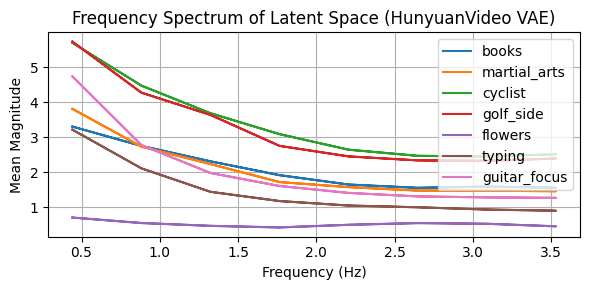

In [41]:
cnt=0
plt.figure(figsize=(6, 3))

selected_filenames=["flowers","books","martial_arts","cyclist","golf_side","typing","guitar_focus"]

cnt=0
for filename in os.listdir(path):
    if filename.endswith(".yuv"):
        name=filename.split('-')[0]
        # if cnt%3==1:
        # if 1:
        if name in selected_filenames:
            plt.plot(datas_latent_x[cnt],datas_latent_y[cnt],'-',label=name)
        cnt+=1
plt.title('Frequency Spectrum of Latent Space (HunyuanVideo VAE)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Magnitude')
# plt.ylim(1,15)
# plt.xlim(0.1,7.5)
plt.grid()
plt.legend()

plt.tight_layout()
# plt.show()
# plt.savefig('output/frequency_analyse.pdf',bbox_inches='tight')

当前工作目录: /mnt/public/wangsiyuan/HunyuanVideo_efficiency
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_1x_720p/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_2x_720p/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_4x_720p/metrics.csv
指标: lpips, 设置: 4Hz, 拟合参数: a=0.0809, b=0.0160, R²=0.4991
指标: lpips, 设置: 2Hz, 拟合参数: a=0.2940, b=0.0217, R²=0.8614
指标: lpips, 设置: 1Hz, 拟合参数: a=0.4906, b=0.0358, R²=0.8902


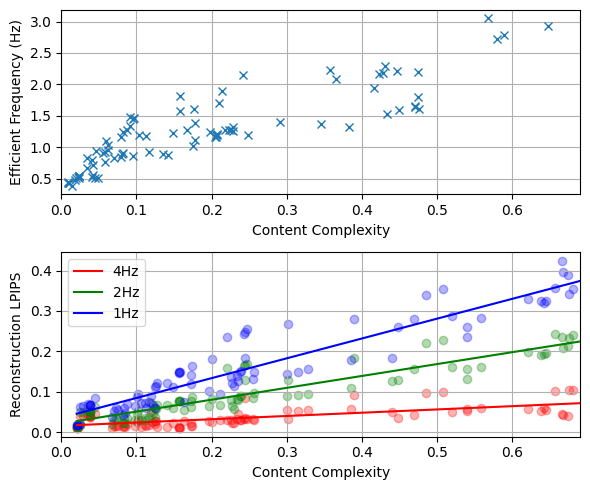

In [73]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义拟合函数，这里以线性函数为例
def linear_func(x, a, b):
    return a * x + b

# 文件路径列表
file_paths = [
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_1x_720p/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_2x_720p/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_4x_720p/metrics.csv'
]

# 标签列表，用于图例
colors = ['r', 'g', 'b']

# 存储拟合参数
fit_params = {'psnr': [], 'ssim': [], 'lpips': []}

# 存储每个文件的数据
data_list = []

# 打印当前工作目录
print(f"当前工作目录: {os.getcwd()}")

# 检查每个文件是否存在并读取
for path in file_paths:
    if not os.path.isfile(path):
        print(f"文件不存在: {path}")
    else:
        print(f"文件存在: {path}")
        try:
            df = pd.read_csv(path)
            
            # 确保 'tile_ci' 被转换为浮点数
            df['tile_ci'] = pd.to_numeric(df['tile_ci'], errors='coerce')
            
            # 选择数值类型的列
            numeric_cols = ['tile_ci', 'psnr', 'ssim', 'lpips']
            df_numeric = df[numeric_cols].dropna()  # 去除可能的NaN值
            
            # 按 tile_ci 分组，计算每个 tile_ci 的平均值
            df_grouped = df_numeric.groupby('tile_ci').mean().reset_index()
            data_list.append(df_grouped)
        except Exception as e:
            print(f"读取文件失败 {path}: {e}")

# 确保所有文件都存在后继续
if len(data_list) != len(file_paths):
    print("部分文件缺失，无法继续拟合和绘图。")
    sys.exit(1)

# 定义指标
metrics = ['lpips']

labels = ['4Hz', '2Hz', '1Hz']
plt.figure(figsize=(6, 5))
plt.subplot(2,1,2)
# 对每个指标进行独立绘图
for metric in metrics:
    for i, df in enumerate(data_list):
        x = 1-df['tile_ci'].values
        y = df[metric].values
        # 拟合
        try:
            popt, _ = curve_fit(linear_func, x, y, method='dogbox',sigma=1)
            fit_params[metric].append(popt)
            # 生成拟合曲线
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = linear_func(x_fit, *popt)
            plt.plot(x_fit, y_fit, color=colors[i], label=labels[i])
            # 输出拟合参数和拟合质量
            a, b = popt
            y_pred = linear_func(x, a, b)
            r2 = np.corrcoef(y, y_pred)[0, 1]**2
            print(f"指标: {metric}, 设置: {labels[i]}, 拟合参数: a={a:.4f}, b={b:.4f}, R²={r2:.4f}")
        except Exception as e:
            print(f"拟合失败 for {metric} in {labels[i]}: {e}")
            fit_params[metric].append([np.nan, np.nan])
        
        # 绘制原始数据点
        plt.scatter(x, y, color=colors[i], alpha=0.3)
    plt.xlabel('Content Complexity')
    plt.ylabel('Reconstruction LPIPS')
    plt.legend()
    plt.tight_layout()

plt.grid()
plt.xlim(0,0.69)

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
def linear_func(x, a, b):
    return a * x + b

# plt.figure(figsize=(6, 3))
plt.subplot(2,1,1)
for mag_threshold in [1.8]:
    freq_effs=[]
    freq_effs2=[]
    for i in range(len(datas_ci)):
        freq=datas_latent_x[i]
        mag=datas_latent_y[i]
        freq_ind=np.argsort(freq)
        mag=mag[freq_ind]
        freq=freq[freq_ind]
        
        f_interp = interp1d(freq,mag, kind='linear', fill_value='extrapolate')

        freq_eff = f_interp(mag_threshold)
        freq_effs.append(freq_eff)
    plt.plot(datas_ci,freq_effs,'x',label=f"ε={mag_threshold}")
    # popt, _ = curve_fit(linear_func, np.array(datas_ci), np.array(freq_effs), method='dogbox',sigma=1)
    # # 生成拟合曲线
    # x_fit = np.linspace(x.min(), x.max(), 100)
    # y_fit = linear_func(x_fit, *popt)
    # plt.plot(x_fit, y_fit, label='fit curve')
    # plt.plot(datas_ci,freq_effs2,'o',label=f"ε={mag_threshold}")
# plt.title('Complexity and Efficient Frequency')
plt.xlabel('Content Complexity')
plt.ylabel('Efficient Frequency (Hz)')
plt.xlim(0,0.69)
plt.grid()
plt.tight_layout()
# plt.show()
plt.savefig('output/frequency_analyse_eff.pdf',bbox_inches='tight')




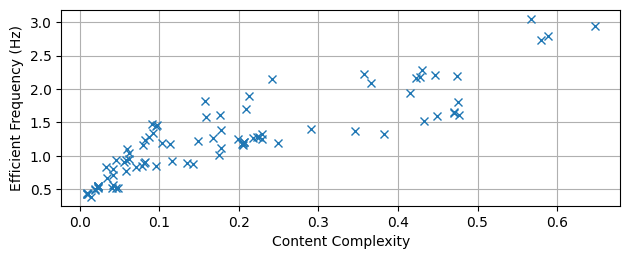

In [69]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
def linear_func(x, a, b):
    return a * x + b

# plt.figure(figsize=(6, 3))
plt.subplot(2,1,2)
for mag_threshold in [1.8]:
    freq_effs=[]
    freq_effs2=[]
    for i in range(len(datas_ci)):
        freq=datas_latent_x[i]
        mag=datas_latent_y[i]
        freq_ind=np.argsort(freq)
        mag=mag[freq_ind]
        freq=freq[freq_ind]
        
        f_interp = interp1d(freq,mag, kind='linear', fill_value='extrapolate')

        freq_eff = f_interp(mag_threshold)
        freq_effs.append(freq_eff)
    plt.plot(datas_ci,freq_effs,'x',label=f"ε={mag_threshold}")
    # popt, _ = curve_fit(linear_func, np.array(datas_ci), np.array(freq_effs), method='dogbox',sigma=1)
    # # 生成拟合曲线
    # x_fit = np.linspace(x.min(), x.max(), 100)
    # y_fit = linear_func(x_fit, *popt)
    # plt.plot(x_fit, y_fit, label='fit curve')
    # plt.plot(datas_ci,freq_effs2,'o',label=f"ε={mag_threshold}")
# plt.title('Complexity and Efficient Frequency')
plt.xlabel('Content Complexity')
plt.ylabel('Efficient Frequency (Hz)')
plt.grid()
plt.tight_layout()
# plt.show()
plt.savefig('output/frequency_analyse_eff.pdf',bbox_inches='tight')


当前工作目录: /mnt/public/wangsiyuan/HunyuanVideo_efficiency
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_1x_720p/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_2x_720p/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_4x_720p/metrics.csv
指标: lpips, 设置: 4Hz, 拟合参数: a=0.0809, b=0.0160, R²=0.4991
指标: lpips, 设置: 2Hz, 拟合参数: a=0.2940, b=0.0217, R²=0.8614
指标: lpips, 设置: 1Hz, 拟合参数: a=0.4906, b=0.0358, R²=0.8902


0.38636363636363635

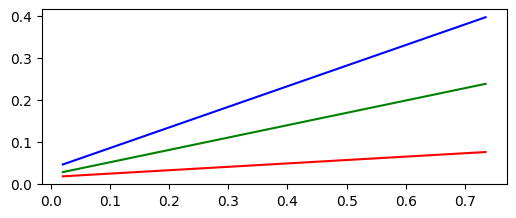

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义拟合函数，这里以线性函数为例
def linear_func(x, a, b):
    return a * x + b

# 文件路径列表
file_paths = [
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_1x_720p/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_2x_720p/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_30hz_ssim_4x_720p/metrics.csv'
]

# 标签列表，用于图例
colors = ['r', 'g', 'b']

# 存储拟合参数
fit_params = {'psnr': [], 'ssim': [], 'lpips': []}

# 存储每个文件的数据
data_list = []

# 打印当前工作目录
print(f"当前工作目录: {os.getcwd()}")

# 检查每个文件是否存在并读取
for path in file_paths:
    if not os.path.isfile(path):
        print(f"文件不存在: {path}")
    else:
        print(f"文件存在: {path}")
        try:
            df = pd.read_csv(path)
            
            # 确保 'tile_ci' 被转换为浮点数
            df['tile_ci'] = pd.to_numeric(df['tile_ci'], errors='coerce')
            
            # 选择数值类型的列
            numeric_cols = ['tile_ci', 'psnr', 'ssim', 'lpips']
            df_numeric = df[numeric_cols].dropna()  # 去除可能的NaN值
            
            # 按 tile_ci 分组，计算每个 tile_ci 的平均值
            df_grouped = df_numeric.groupby('tile_ci').mean().reset_index()
            data_list.append(df_grouped)
        except Exception as e:
            print(f"读取文件失败 {path}: {e}")

# 确保所有文件都存在后继续
if len(data_list) != len(file_paths):
    print("部分文件缺失，无法继续拟合和绘图。")
    sys.exit(1)

# 定义指标
metrics = ['lpips']

labels = ['4Hz', '2Hz', '1Hz']
plt.figure(figsize=(6, 5))
plt.subplot(2,1,2)
# 对每个指标进行独立绘图
for metric in metrics:
    for i, df in enumerate(data_list):
        x = 1-df['tile_ci'].values
        y = df[metric].values
        # 拟合
        try:
            popt, _ = curve_fit(linear_func, x, y, method='dogbox',sigma=1)
            fit_params[metric].append(popt)
            # 生成拟合曲线
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = linear_func(x_fit, *popt)
            plt.plot(x_fit, y_fit, color=colors[i], label=labels[i])
            # 输出拟合参数和拟合质量
            a, b = popt
            y_pred = linear_func(x, a, b)
            r2 = np.corrcoef(y, y_pred)[0, 1]**2
            print(f"指标: {metric}, 设置: {labels[i]}, 拟合参数: a={a:.4f}, b={b:.4f}, R²={r2:.4f}")
        except Exception as e:
            print(f"拟合失败 for {metric} in {labels[i]}: {e}")
            fit_params[metric].append([np.nan, np.nan])
        
        # 绘制原始数据点
#         plt.scatter(x, y, color=colors[i], alpha=0.3)
#     plt.xlabel('Content Complexity')
#     plt.ylabel('Reconstruction LPIPS')
#     plt.legend()
#     plt.tight_layout()

# plt.grid()
# plt.xlim(0,0.69)
(x<0.7/5).mean()
